3.2 Classification and regression with a two-layer perceptron




Generate some data 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import trange
from abc import ABCMeta, abstractmethod

def generate_data(mA=(1, 1), mB=(5, 1), sigmaA=1, sigmaB=1, type='random'):
    np.random.seed(100)
    A = np.random.randn(256, 2) * sigmaA + mA
    B = np.random.randn(256, 2) * sigmaB + mB
    labels = np.concatenate((np.ones(A.shape[0]), -np.ones(B.shape[0])))
    samples = np.concatenate((A, B))
    permute = np.random.permutation(A.shape[0] + B.shape[0])
    return samples[permute, :], labels[permute]

Def of NN

In [2]:

class Parameter(object):
    def __init__(self, data, requires_grad, skip_decay=False):
        self.data = data
        self.grad = None
        self.skip_decay = skip_decay
        self.requires_grad = requires_grad

    @property
    def T(self):
        return self.data.T

class SGD(object):
    def __init__(self, parameters, lr, decay=0):
        self.parameters = [p for p in parameters if p.requires_grad]   
        self.lr = lr
        self.decay_rate = 1.0 - decay

    def update(self):
        for p in self.parameters:
            if self.decay_rate < 1 and not p.skip_decay: p.data *= self.decay_rate
           # print("data",p.data,"grad",p.grad)
            p.data -= self.lr * p.grad


class MSE:
    def __init__(self):
        pass
    def gradient(self):
        return self.a - self.y
    
    def __call__(self, output, target, requires_acc=True):
        self.a = output
        self.y = np.reshape(target,(-1,1))
        loss = 0.5*np.multiply(self.a-self.y,self.a-self.y).mean()
        if requires_acc:
            acc = np.sum(np.sign(output)==self.y)/output.shape[0]
            return loss,acc
        return loss

class Layer():
    @abstractmethod
    def forward(self, *args):
        pass

    @abstractmethod
    def backward(self, *args):
        pass

class Tanh(Layer):
    def forward(self, x):
        ex = np.exp(x)
        esx = np.exp(-x)
        self.y = (ex - esx) / (ex + esx)
        return self.y

    def backward(self, eta):
        return np.einsum('...,...,...->...', 1 - self.y, 1 + self.y, eta, optimize=True)

class Linear(Layer):
    def __init__(self, shape, requires_grad=True, bias=True, **kwargs):
        '''
        shape = (in_size, out_size)
        '''
        W = np.random.randn(*shape) * (2 / shape[0]**0.5)
      #  print(W.shape)
        self.W = Parameter(W, requires_grad)
        self.b = Parameter(np.zeros(shape[-1]), requires_grad) if bias else None
        self.require_grad = requires_grad

    def forward(self, x):
        if self.require_grad: self.x = x
        out = np.dot(x, self.W.data)
        if self.b is not None: out = out + self.b.data
        return out

    def backward(self, eta):
       if self.require_grad:
            batch_size = eta.shape[0]
            self.W.grad = np.dot(self.x.T, eta) / batch_size
            if self.b is not None: self.b.grad = np.sum(eta, axis=0) / batch_size
       return np.dot(eta, self.W.T)
class Net(Layer):
    def __init__(self, layer_configures):
        self.layers = []
        self.parameters=[]
        for config in layer_configures:
            self.layers.append(self.createLayer(config))

    def createLayer(self, config):
        return self.getDefaultLayer(config)

    def getDefaultLayer(self, config):
        t = config['type']
        if t == 'linear':
            layer = Linear(**config)
            self.parameters.append(layer.W)
            if layer.b is not None: self.parameters.append(layer.b)
        elif t == 'tanh':
            layer = Tanh()
        return layer

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, eta):
        for layer in self.layers[::-1]:
            eta = layer.backward(eta)
        return eta
    
    def train(self,X,Y,optimizer,batch_size=16,epochs=500,loss=MSE()):
        n = len(Y)
        for epoch in trange(epochs):
            i = 0 
            while i<= n-batch_size:
                x,y=X[i:i+batch_size,],Y[i:i+batch_size,]
                i+=batch_size
                output = self.forward(x)
                batch_loss, batch_acc = loss(output,y)
                eta = loss.gradient()
                self.backward(eta)
                optimizer.update()
                if epoch % 40:
                    print("epoch: %d, batch: %5d, batch_acc:    %.2f,batch loss: %.2f" % \
                    (epoch, i/batch_size,batch_acc*100,batch_loss))



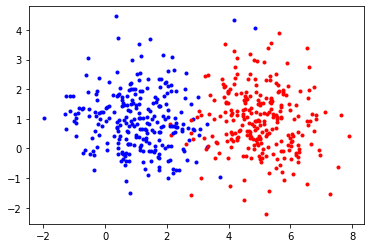

100%|██████████| 500/500 [00:14<00:00, 35.51it/s]


epoch: 1, batch:     1, batch_acc:    62.50,batch loss: 0.65
epoch: 1, batch:     2, batch_acc:    75.00,batch loss: 0.42
epoch: 1, batch:     3, batch_acc:    81.25,batch loss: 0.35
epoch: 1, batch:     4, batch_acc:    87.50,batch loss: 0.31
epoch: 1, batch:     5, batch_acc:    62.50,batch loss: 0.58
epoch: 1, batch:     6, batch_acc:    75.00,batch loss: 0.52
epoch: 1, batch:     7, batch_acc:    62.50,batch loss: 0.74
epoch: 1, batch:     8, batch_acc:    87.50,batch loss: 0.36
epoch: 1, batch:     9, batch_acc:    75.00,batch loss: 0.42
epoch: 1, batch:    10, batch_acc:    68.75,batch loss: 0.61
epoch: 1, batch:    11, batch_acc:    81.25,batch loss: 0.31
epoch: 1, batch:    12, batch_acc:    62.50,batch loss: 0.60
epoch: 1, batch:    13, batch_acc:    62.50,batch loss: 0.67
epoch: 1, batch:    14, batch_acc:    81.25,batch loss: 0.40
epoch: 1, batch:    15, batch_acc:    81.25,batch loss: 0.22
epoch: 1, batch:    16, batch_acc:    50.00,batch loss: 0.69
epoch: 1, batch:    17, 

In [3]:

X,Y = generate_data()
for i, it in enumerate(X):
    if Y[i] == -1:
        plt.plot(X[i][0], X[i][1], 'r.')
    else:
        plt.plot(X[i][0], X[i][1], 'b.')
plt.show()
layers =[
    {'type':'linear','shape':(2,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,6)},
    {'type':'tanh'},
    {'type':'linear','shape':(6,1)},
    {'type':'tanh'}
]
net = Net(layers)
opt = SGD(net.parameters,lr=1e-3)
net.train(X,Y,opt)


1. Modify the number of hidden nodes and demonstrate the effect the size of the hidden layer has on the performance (both the mean squared error and the number/ratio of misclassifications). How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?


## 3.2.3 Function approximation

data generate
